# HERON Tutorial: Action Passing Through Agent Hierarchy

This notebook demonstrates **action passing through protocols** in HERON's hierarchical multi-agent system:

1. **Coordinator owns neural policy** and computes joint actions
2. **Protocol distributes actions** to subordinate field agents
3. **CTDE Training**: Centralized policy learning with distributed execution
4. **Event-Driven Testing**: Asynchronous action distribution with realistic timing

## Architecture

```
GridSystem (L3)
    |
    v
ZoneCoordinator (L2) <-- Owns policy, computes joint action
    |                    Protocol distributes actions
    +--> DeviceAgent (L1) - Device 1 (receives action via protocol)
    |
    +--> DeviceAgent (L1) - Device 2 (receives action via protocol)
```

## Key Concepts

**Action Protocol**: Defines how coordinator actions are distributed to subordinates
- **VectorDecomposition**: Split joint action vector [a1, a2] → device_1 gets a1, device_2 gets a2
- **Proportional**: Distribute scalar action proportionally based on weights
- **Custom**: Implement your own action distribution logic

**CTDE Pattern**:
- **Training**: Coordinator observes all devices, outputs joint action, protocol distributes
- **Execution**: Same flow, but with asynchronous timing and message passing

## Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Any, Dict, List, Optional
from dataclasses import dataclass

# HERON imports
from heron.agents.field_agent import FieldAgent
from heron.agents.coordinator_agent import CoordinatorAgent
from heron.agents.system_agent import SystemAgent
from heron.core.observation import Observation
from heron.core.feature import FeatureProvider
from heron.core.action import Action
from heron.core.policies import Policy, obs_to_vector, vector_to_action
from heron.envs.base import HeronEnv
from heron.protocols.base import ActionProtocol, Protocol
from heron.protocols.vertical import VerticalProtocol
from heron.scheduling import EventScheduler, TickConfig, JitterType
from heron.scheduling.analysis import EventAnalyzer
from heron.utils.typing import AgentID

print("HERON modules loaded successfully!")

---
## Part 1: Custom Action Protocol

Let's implement a **ProportionalActionProtocol** that distributes a coordinator's scalar action proportionally among subordinates based on weights.

**ActionProtocol Interface**:
- `compute_action_coordination()`: Takes coordinator action + subordinate states → Returns dict of {agent_id: action}

**Example**: If coordinator outputs action=10.0 with weights [0.3, 0.7]
- device_1 receives: 10.0 × 0.3 = 3.0
- device_2 receives: 10.0 × 0.7 = 7.0

In [ ]:
class ProportionalActionProtocol(ActionProtocol):
    """Distributes coordinator action proportionally based on weights."""

    def __init__(self, distribution_weights: Optional[Dict[AgentID, float]] = None):
        self.distribution_weights = distribution_weights or {}

    def compute_action_coordination(
        self,
        coordinator_action: Optional[Any],
        info_for_subordinates: Optional[Dict[AgentID, Any]] = None,
        coordination_messages: Optional[Dict[AgentID, Dict[str, Any]]] = None,
        context: Optional[Dict[str, Any]] = None
    ) -> Dict[AgentID, Any]:
        """Distribute coordinator action proportionally among subordinates."""
        if coordinator_action is None or info_for_subordinates is None:
            return {sub_id: None for sub_id in (info_for_subordinates or {})}

        # Extract action value from Action object or array
        if hasattr(coordinator_action, 'c'):
            total_action = float(coordinator_action.c[0]) if len(coordinator_action.c) > 0 else 0.0
        elif isinstance(coordinator_action, np.ndarray):
            total_action = float(coordinator_action[0]) if len(coordinator_action) > 0 else 0.0
        else:
            total_action = float(coordinator_action)

        # Compute weights
        sub_ids = list(info_for_subordinates.keys())
        if not sub_ids:
            return {}

        if not self.distribution_weights:
            weights = {sub_id: 1.0 / len(sub_ids) for sub_id in sub_ids}
        else:
            total_weight = sum(self.distribution_weights.get(sub_id, 0.0) for sub_id in sub_ids)
            if total_weight == 0:
                weights = {sub_id: 1.0 / len(sub_ids) for sub_id in sub_ids}
            else:
                weights = {
                    sub_id: self.distribution_weights.get(sub_id, 0.0) / total_weight
                    for sub_id in sub_ids
                }

        # Distribute action proportionally
        actions = {}
        for sub_id in sub_ids:
            proportional_action = total_action * weights[sub_id]
            actions[sub_id] = np.array([proportional_action])

        # Print during event-driven execution
        if context and "subordinates" in context:
            print(f"[ProportionalProtocol] Distributing action {total_action:.4f} -> {[(sid, f'{a[0]:.4f}') for sid, a in actions.items()]}")
            print(f"  Weights: {weights}")
        return actions


class ProportionalProtocol(Protocol):
    """Protocol with proportional action distribution."""

    def __init__(self, distribution_weights: Optional[Dict[AgentID, float]] = None):
        from heron.protocols.base import NoCommunication
        super().__init__(
            communication_protocol=NoCommunication(),
            action_protocol=ProportionalActionProtocol(distribution_weights)
        )

    def coordinate(self, coordinator_state, coordinator_action=None, info_for_subordinates=None, context=None):
        """Override to add debug output."""
        print(f"[ProportionalProtocol.coordinate] Called with action={coordinator_action}, subordinates={list(info_for_subordinates.keys()) if info_for_subordinates else []}")
        return super().coordinate(coordinator_state, coordinator_action, info_for_subordinates, context)


print("ProportionalActionProtocol defined!")
print("  - Distributes scalar coordinator action proportionally")
print("  - Weights can be customized per subordinate")
print("  - Default: equal distribution")

---
## Part 2: Building Agents

### 2.1 Device Feature

In [ ]:
@dataclass(slots=True)
class DevicePowerFeature(FeatureProvider):
    """Power state feature for devices."""
    visibility = ["public"]

    power: float = 0.0
    capacity: float = 1.0

    def set_values(self, **kwargs: Any) -> None:
        if "power" in kwargs:
            self.power = np.clip(kwargs["power"], -self.capacity, self.capacity)
        if "capacity" in kwargs:
            self.capacity = kwargs["capacity"]


print("DevicePowerFeature defined!")

### 2.2 Device Agent (Level 1)

**DeviceAgent** receives actions from coordinator via protocol.

**Key Design**:
- No policy at field agent level (actions come from coordinator)
- `set_action()`: Handles actions from protocol (Action objects or arrays)
- `set_state()`: Updates power based on received action
- `compute_local_reward()`: Reward = minimize power deviation from zero

In [ ]:
class DeviceAgent(FieldAgent):
    """Device field agent - receives actions from coordinator via protocol."""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._reward_history = []  # Store (timestamp, reward) tuples for plotting
        self._last_reward_timestamp = None  # Track last recorded timestamp to avoid duplicates

    @property
    def power(self) -> float:
        return self.state.features["DevicePowerFeature"].power

    @property
    def capacity(self) -> float:
        return self.state.features["DevicePowerFeature"].capacity

    def init_action(self, features: List[FeatureProvider] = []):
        """Initialize action (power control)."""
        action = Action()
        action.set_specs(dim_c=1, range=(np.array([-1.0]), np.array([1.0])))
        action.set_values(np.array([0.0]))
        return action

    def compute_local_reward(self, local_state: dict) -> float:
        """Reward = maintain power near zero (minimize deviation).

        Args:
            local_state: State dict with structure:
                {"DevicePowerFeature": np.array([power, capacity])}

        Returns:
            Reward value (negative squared power deviation)
        """
        reward = 0.0
        if "DevicePowerFeature" in local_state:
            feature_vec = local_state["DevicePowerFeature"]
            power = float(feature_vec[0])  # Power is first element
            reward = -power ** 2  # Penalize deviation from zero

        # Store reward history for plotting (event-driven mode)
        # Avoid duplicates by checking if we've already recorded for this timestamp
        if hasattr(self, '_timestep') and hasattr(self, '_reward_history'):
            current_ts = self._timestep
            if self._last_reward_timestamp != current_ts:
                self._reward_history.append((current_ts, reward))
                self._last_reward_timestamp = current_ts
                # Cache for coordinator aggregation in event-driven mode
                self._last_reward = reward

        return reward

    def set_action(self, action: Any) -> None:
        """Set action from Action object or compatible format."""
        if isinstance(action, Action):
            # Handle potential dimension mismatch - take only what we need
            if len(action.c) != self.action.dim_c:
                self.action.set_values(action.c[:self.action.dim_c])
            else:
                self.action.set_values(c=action.c)
        else:
            # Direct value (numpy array or dict)
            self.action.set_values(action)

    def set_state(self) -> None:
        """Update power based on action (direct setpoint control)."""
        new_power = self.action.c[0] * 0.5  # Scale action to reasonable power range
        self.state.features["DevicePowerFeature"].set_values(power=new_power)

    def apply_action(self):
        self.set_state()


print("DeviceAgent class defined!")
print("  - Simplified compute_local_reward (array-based)")
print("  - Handles dimension mismatch in set_action (protocol coordination)")
print("  - Tracks reward history for event-driven visualization")
print("  - Deduplicates reward recording by timestamp")

### 2.3 Zone Coordinator (Level 2)

**ZoneCoordinator** owns the neural policy and distributes actions via protocol.

**Key Design**:
- Owns policy (computes joint action for all subordinates)
- Protocol distributes coordinator's action to field agents
- Aggregates rewards from all subordinates

In [6]:
class ZoneCoordinator(CoordinatorAgent):
    """Coordinator - owns policy and distributes actions via protocol."""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._reward_history = []  # Store (timestamp, reward) tuples for plotting
        self._last_reward_timestamp = None  # Track last recorded timestamp to avoid duplicates

    def compute_local_reward(self, local_state: dict) -> float:
        """Aggregate subordinate rewards for monitoring.

        In event-driven mode, this provides visibility into aggregated performance.
        Note: Training code manually aggregates field agent rewards, so this doesn't affect training.
        """
        total_reward = 0.0

        # Aggregate rewards from subordinates by accessing their cached values
        # In event-driven mode, _last_reward is set in DeviceAgent.compute_local_reward()
        for subordinate in self.subordinates.values():
            if hasattr(subordinate, '_last_reward'):
                total_reward += subordinate._last_reward

        # Store reward history for plotting (event-driven mode)
        # Avoid duplicates by checking if we've already recorded for this timestamp
        if hasattr(self, '_timestep') and hasattr(self, '_reward_history'):
            current_ts = self._timestep
            if self._last_reward_timestamp != current_ts:
                self._reward_history.append((current_ts, total_reward))
                self._last_reward_timestamp = current_ts

        return total_reward

    def compute_rewards(self, proxy: "ProxyAgent") -> Dict[AgentID, float]:
        """Override to cache subordinate rewards for aggregation."""
        rewards = {}

        # Collect subordinate rewards and cache them
        for subordinate in self.subordinates.values():
            sub_rewards = subordinate.compute_rewards(proxy)
            rewards.update(sub_rewards)
            # Cache subordinate's reward for later aggregation
            if subordinate.agent_id in sub_rewards:
                subordinate._last_reward = sub_rewards[subordinate.agent_id]

        # Compute coordinator's aggregated reward
        local_state = proxy.get_local_state(self.agent_id, self.protocol)
        coordinator_reward = self.compute_local_reward(local_state)
        rewards[self.agent_id] = coordinator_reward

        return rewards


class GridSystem(SystemAgent):
    """System agent for grid management."""
    pass


print("ZoneCoordinator and GridSystem classes defined!")
print("  - Coordinator aggregates subordinate rewards")
print("  - Tracks reward history for visualization")
print("  - Deduplicates reward recording by timestamp")
print("  - System agent uses base with framework termination check")

ZoneCoordinator and GridSystem classes defined!
  - Coordinator aggregates subordinate rewards
  - Tracks reward history for visualization
  - Deduplicates reward recording by timestamp
  - System agent uses base with framework termination check


---
## Part 3: Environment

**ActionPassingEnv** provides the interface for action passing through protocols.

In [ ]:
class EnvState:
    """Environment state tracking device power levels."""
    def __init__(self, device_powers: Optional[Dict[str, float]] = None):
        self.device_powers = device_powers or {"device_1": 0.0, "device_2": 0.0}


class ActionPassingEnv(HeronEnv):
    """Environment for testing action passing through protocols."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def run_simulation(self, env_state: EnvState, *args, **kwargs) -> EnvState:
        """Physics simulation - clip power values to valid range."""
        for device_id in env_state.device_powers:
            # Clip power to reasonable range based on capacity (assume capacity=1.0)
            env_state.device_powers[device_id] = np.clip(
                env_state.device_powers[device_id], -1.0, 1.0
            )
        return env_state

    def env_state_to_global_state(self, env_state: EnvState) -> Dict:
        """Convert env_state to global_state format.

        Constructs global state PURELY from env_state, not from agent internal states.
        This maintains proper separation of concerns between environment and agents.

        Args:
            env_state: Environment state after simulation

        Returns:
            Dict with structure: {"agent_states": {agent_id: state_dict, ...}}
        """
        from heron.agents.constants import FIELD_LEVEL, COORDINATOR_LEVEL, SYSTEM_LEVEL

        # Map agent level to state type
        level_to_state_type = {
            FIELD_LEVEL: "FieldAgentState",
            COORDINATOR_LEVEL: "CoordinatorAgentState",
            SYSTEM_LEVEL: "SystemAgentState"
        }

        agent_states = {}

        # Create state dicts for device agents based on simulation results
        for agent_id, agent in self.registered_agents.items():
            # Only create states for field-level device agents
            if hasattr(agent, 'level') and agent.level == FIELD_LEVEL and 'device' in agent_id:
                power_value = env_state.device_powers.get(agent_id, 0.0)
                agent_states[agent_id] = {
                    "_owner_id": agent_id,
                    "_owner_level": agent.level,
                    "_state_type": level_to_state_type[agent.level],
                    "features": {
                        "DevicePowerFeature": {
                            "power": power_value,
                            "capacity": 1.0
                        }
                    }
                }

        return {"agent_states": agent_states}

    def global_state_to_env_state(self, global_state: Dict) -> EnvState:
        """Convert global state to env state.

        Args:
            global_state: Global state dict with structure:
                {"agent_states": {agent_id: state_dict, ...}}

        Returns:
            EnvState with extracted device power values
        """
        # Access the nested agent_states dict
        agent_states = global_state.get("agent_states", {})

        device_powers = {}
        # Extract power from each device agent's state dict
        for agent_id, state_dict in agent_states.items():
            if 'device' in agent_id and "features" in state_dict:
                features = state_dict["features"]
                if "DevicePowerFeature" in features:
                    power_feature = features["DevicePowerFeature"]
                    device_powers[agent_id] = power_feature.get("power", 0.0)

        # Fallback to default powers if no device states found
        if not device_powers:
            device_powers = {"device_1": 0.0, "device_2": 0.0}

        return EnvState(device_powers=device_powers)


print("ActionPassingEnv defined with meaningful state!")
print("  - EnvState tracks device_powers (dict)")
print("  - run_simulation clips power values")
print("  - Proper env ↔ agent state separation")

---
## Part 4: Neural Policy for Coordinator

**CoordinatorNeuralPolicy** computes joint action for all subordinates.

**Architecture**:
- Input: Aggregated observations from all subordinates
- Output: Joint action (dimension = number of subordinates)
- Training: Policy gradient with advantage
- Critic: Value function baseline

In [8]:
class SimpleMLP:
    """Simple MLP for value function approximation."""
    def __init__(self, input_dim, hidden_dim, output_dim, seed=42):
        np.random.seed(seed)
        self.W1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2.0 / input_dim)
        self.b1 = np.zeros(hidden_dim)
        self.W2 = np.random.randn(hidden_dim, output_dim) * np.sqrt(2.0 / hidden_dim)
        self.b2 = np.zeros(output_dim)

    def forward(self, x):
        h = np.maximum(0, x @ self.W1 + self.b1)
        return np.tanh(h @ self.W2 + self.b2)

    def update(self, x, target, lr=0.01):
        h = np.maximum(0, x @ self.W1 + self.b1)
        out = np.tanh(h @ self.W2 + self.b2)
        d_out = (out - target) * (1 - out**2)
        self.W2 -= lr * np.outer(h, d_out)
        self.b2 -= lr * d_out
        d_h = d_out @ self.W2.T
        d_h[h <= 0] = 0
        self.W1 -= lr * np.outer(x, d_h)
        self.b1 -= lr * d_h


class ActorMLP(SimpleMLP):
    """Actor network with tanh output."""
    def __init__(self, input_dim, hidden_dim, output_dim, seed=42):
        super().__init__(input_dim, hidden_dim, output_dim, seed)
        self.W2 = np.random.randn(hidden_dim, output_dim) * 0.1
        self.b2 = np.zeros(output_dim)

    def update(self, x, action_taken, advantage, lr=0.01):
        """Update actor using policy gradient."""
        h = np.maximum(0, x @ self.W1 + self.b1)
        current_action = np.tanh(h @ self.W2 + self.b2)

        error = current_action - action_taken
        grad_scale = advantage * (1 - current_action**2)

        d_W2 = np.outer(h, grad_scale * error)
        d_b2 = grad_scale * error
        d_h = (grad_scale * error) @ self.W2.T
        d_h[h <= 0] = 0
        d_W1 = np.outer(x, d_h)
        d_b1 = d_h

        self.W2 -= lr * d_W2
        self.b2 -= lr * d_b2.flatten()
        self.W1 -= lr * d_W1
        self.b1 -= lr * d_b1.flatten()


class CoordinatorNeuralPolicy(Policy):
    """Neural policy for coordinator that computes joint action.

    The coordinator observes all subordinate states (aggregated) and outputs
    a single action that will be distributed to subordinates via protocol.
    """
    def __init__(self, obs_dim, action_dim=1, hidden_dim=32, seed=42):
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.action_range = (-1.0, 1.0)
        self.hidden_dim = hidden_dim

        self.actor = ActorMLP(obs_dim, hidden_dim, action_dim, seed)
        self.critic = SimpleMLP(obs_dim, hidden_dim, 1, seed + 1)

        self.noise_scale = 0.15

    @obs_to_vector
    @vector_to_action
    def forward(self, obs_vec: np.ndarray) -> np.ndarray:
        """Compute joint action with exploration noise."""
        action_mean = self.actor.forward(obs_vec)
        action_vec = action_mean + np.random.normal(0, self.noise_scale, self.action_dim)
        action_clipped = np.clip(action_vec, -1.0, 1.0)
        return action_clipped

    @obs_to_vector
    @vector_to_action
    def forward_deterministic(self, obs_vec: np.ndarray) -> np.ndarray:
        """Compute joint action without exploration noise."""
        return self.actor.forward(obs_vec)

    @obs_to_vector
    def get_value(self, obs_vec: np.ndarray) -> float:
        """Estimate value of current state."""
        return float(self.critic.forward(obs_vec)[0])

    def update(self, obs, action_taken, advantage, lr=0.01):
        """Update policy using policy gradient with advantage."""
        self.actor.update(obs, action_taken, advantage, lr)

    def update_critic(self, obs, target, lr=0.01):
        """Update critic to better estimate values."""
        self.critic.update(obs, np.array([target]), lr)

    def decay_noise(self, decay_rate=0.995, min_noise=0.05):
        """Decay exploration noise over training."""
        self.noise_scale = max(min_noise, self.noise_scale * decay_rate)


print("CoordinatorNeuralPolicy defined!")
print("  - Observes all subordinates (aggregated)")
print("  - Outputs joint action for all subordinates")
print("  - Protocol distributes action to field agents")

CoordinatorNeuralPolicy defined!
  - Observes all subordinates (aggregated)
  - Outputs joint action for all subordinates
  - Protocol distributes action to field agents


---
## Part 5: Create Environment and Agents

Now let's create the agent hierarchy with **VerticalProtocol** for vector decomposition.

In [9]:
# Create devices
device_1 = DeviceAgent(
    agent_id="device_1",
    features=[DevicePowerFeature(power=0.0, capacity=1.0)]
)
device_2 = DeviceAgent(
    agent_id="device_2",
    features=[DevicePowerFeature(power=0.0, capacity=1.0)]
)

# Configure tick timing for event-driven mode
field_tick_config = TickConfig.with_jitter(
    tick_interval=2.0,
    obs_delay=0.05,
    act_delay=0.1,
    msg_delay=0.05,
    jitter_type=JitterType.GAUSSIAN,
    jitter_ratio=0.1,
    seed=42
)

coordinator_tick_config = TickConfig.with_jitter(
    tick_interval=4.0,
    obs_delay=0.1,
    act_delay=0.15,
    msg_delay=0.075,
    jitter_type=JitterType.GAUSSIAN,
    jitter_ratio=0.1,
    seed=43
)

system_tick_config = TickConfig.with_jitter(
    tick_interval=8.0,
    obs_delay=0.15,
    act_delay=0.25,
    msg_delay=0.1,
    jitter_type=JitterType.GAUSSIAN,
    jitter_ratio=0.1,
    seed=44
)

# Set tick configs
device_1.tick_config = field_tick_config
device_2.tick_config = field_tick_config

# Coordinator with VerticalProtocol (vector decomposition)
vertical_protocol = VerticalProtocol()
coordinator = ZoneCoordinator(
    agent_id="coordinator",
    subordinates={"device_1": device_1, "device_2": device_2},
    tick_config=coordinator_tick_config,
)
# WORKAROUND: Set protocol after init
coordinator.protocol = vertical_protocol

system = GridSystem(
    agent_id="system_agent",
    subordinates={"coordinator": coordinator},
    tick_config=system_tick_config,
)

# Create environment
env = ActionPassingEnv(
    system_agent=system,
    scheduler_config={"start_time": 0.0, "time_step": 1.0},
    message_broker_config={"buffer_size": 1000, "max_queue_size": 100},
    simulation_wait_interval=0.01,
)

print("Environment and agent hierarchy created!")
print(f"  Protocol: VerticalProtocol (VectorDecomposition)")
print(f"  Coordinator outputs 2-dimensional action vector [a1, a2]")
print(f"  Protocol decomposes: device_1 gets a1, device_2 gets a2")
print(f"\nRegistered agents: {list(env.registered_agents.keys())}")

Environment and agent hierarchy created!
  Protocol: VerticalProtocol (VectorDecomposition)
  Coordinator outputs 2-dimensional action vector [a1, a2]
  Protocol decomposes: device_1 gets a1, device_2 gets a2

Registered agents: ['system_agent', 'coordinator', 'device_1', 'device_2', 'proxy_agent']


---
## Part 6: CTDE Training

Train the coordinator's policy using CTDE:
1. Coordinator observes all subordinates (aggregated)
2. Coordinator computes joint action
3. Protocol distributes actions to field agents
4. Update policy using aggregated rewards

In [ ]:
def train_ctde(env: HeronEnv, num_episodes=50, steps_per_episode=30, gamma=0.99, lr=0.02):
    """Train coordinator policy using CTDE with action distribution via protocol."""
    # Get field agent IDs
    agent_ids = [aid for aid, agent in env.registered_agents.items() if agent.action_space is not None]

    obs, _ = env.reset(seed=0)

    # Observation dimension: aggregate all field agent observations
    first_obs = obs[agent_ids[0]]
    local_vec = list(first_obs.local.values())[0] if first_obs.local else np.array([])
    obs_dim_per_agent = local_vec.shape[0] if hasattr(local_vec, 'shape') else 0
    obs_dim = obs_dim_per_agent * len(agent_ids)

    print(f"Training coordinator with obs_dim={obs_dim} (aggregated from {len(agent_ids)} agents)")

    # Coordinator policy outputs joint action
    num_subordinates = len(agent_ids)
    coordinator_policy = CoordinatorNeuralPolicy(obs_dim=obs_dim, action_dim=num_subordinates, seed=42)

    returns_history, power_history = [], []

    for episode in range(num_episodes):
        obs, _ = env.reset(seed=episode)

        trajectories = {"obs": [], "actions": [], "rewards": []}
        episode_return = 0.0
        power_values = []

        for step in range(steps_per_episode):
            # Coordinator observes all subordinates
            aggregated_obs = []
            for aid in agent_ids:
                obs_value = obs[aid]
                if isinstance(obs_value, Observation):
                    local_features = list(obs_value.local.values())
                    obs_vec = local_features[0] if local_features else np.array([])
                else:
                    obs_vec = obs_value[:obs_dim_per_agent]
                aggregated_obs.append(obs_vec)

            aggregated_obs_vec = np.concatenate(aggregated_obs)
            coordinator_observation = Observation(timestamp=step, local={"obs": aggregated_obs_vec})

            # Coordinator computes joint action
            coordinator_action = coordinator_policy.forward(coordinator_observation)

            # Protocol distributes actions
            coordinator_agent = env.registered_agents.get("coordinator")
            if coordinator_agent and coordinator_agent.protocol:
                _, distributed_actions = coordinator_agent.protocol.coordinate(
                    coordinator_state=coordinator_agent.state,
                    coordinator_action=coordinator_action,
                    info_for_subordinates={aid: obs[aid] for aid in agent_ids},
                    context={"subordinates": coordinator_agent.subordinates}
                )
                actions = distributed_actions
            else:
                actions = {aid: coordinator_action for aid in agent_ids}

            trajectories["obs"].append(aggregated_obs_vec)
            trajectories["actions"].append(coordinator_action.c.copy())

            obs, rewards, terminated, _, info = env.step(actions)

            # Aggregate rewards
            total_reward = sum(rewards.get(aid, 0) for aid in agent_ids)
            trajectories["rewards"].append(total_reward)
            episode_return += total_reward

            # Track power values
            for aid in agent_ids:
                if aid in obs:
                    obs_value = obs[aid]
                    if isinstance(obs_value, Observation):
                        power_values.append(obs_value.vector()[0])
                    else:
                        power_values.append(obs_value[0])

            if terminated.get("__all__", False) or all(terminated.get(aid, False) for aid in agent_ids):
                break

        # Update coordinator policy
        if trajectories["rewards"]:
            returns = []
            G = 0
            for r in reversed(trajectories["rewards"]):
                G = r + gamma * G
                returns.insert(0, G)
            returns = np.array(returns)

            for t in range(len(trajectories["obs"])):
                obs_t = trajectories["obs"][t]
                baseline = coordinator_policy.get_value(Observation(timestamp=t, local={"obs": obs_t}))
                advantage = returns[t] - baseline
                coordinator_policy.update(obs_t, trajectories["actions"][t], advantage, lr=lr)
                coordinator_policy.update_critic(obs_t, returns[t], lr=lr)

            coordinator_policy.decay_noise()

        returns_history.append(episode_return)
        power_history.append(np.mean(power_values) if power_values else 0)

        if (episode + 1) % 10 == 0:
            print(f"Episode {episode + 1:3d}: return={episode_return:.1f}, avg_power={np.mean(power_values) if power_values else 0:.4f}")

    return coordinator_policy, returns_history, power_history


# Run training
print("="*80)
print("CTDE Training with Action Distribution via Protocol")
print("="*80)
print("Coordinator computes joint action → Protocol distributes to field agents")
print()

coordinator_policy, returns, avg_powers = train_ctde(env, num_episodes=50, steps_per_episode=30, lr=0.02)

initial_avg_power = np.mean(avg_powers[:10])
final_avg_power = np.mean(avg_powers[-10:])
initial_return = np.mean(returns[:10])
final_return = np.mean(returns[-10:])

print(f"\nTraining Results:")
print(f"  Initial avg power: {initial_avg_power:.4f} (return: {initial_return:.2f})")
print(f"  Final avg power:   {final_avg_power:.4f} (return: {final_return:.2f})")
print(f"  Return improvement: {final_return - initial_return:.2f}")
print(f"  Power closer to zero: {abs(initial_avg_power) > abs(final_avg_power)}")

### Plot Training Progress

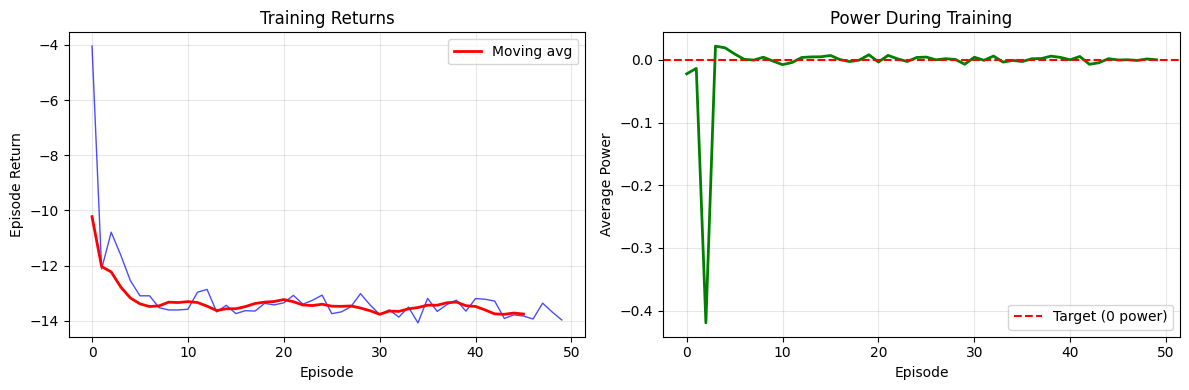

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(returns, 'b-', linewidth=1, alpha=0.7)
axes[0].plot(np.convolve(returns, np.ones(5)/5, mode='valid'), 'r-', linewidth=2, label='Moving avg')
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Episode Return')
axes[0].set_title('Training Returns')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(avg_powers, 'g-', linewidth=2)
axes[1].axhline(y=0.0, color='red', linestyle='--', label='Target (0 power)')
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('Average Power')
axes[1].set_title('Power During Training')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Part 7: Event-Driven Testing

Now let's test the trained policy in event-driven mode with asynchronous timing.

In [12]:
# Attach trained policy to coordinator
print("Attaching trained policy to coordinator for event-driven execution...")
env_coordinator = env.registered_agents.get("coordinator")
if env_coordinator:
    env_coordinator.policy = coordinator_policy
    print(f"  Policy set on coordinator: {env_coordinator.policy is not None}")

# Clear reward histories from training before event-driven execution
print("\nClearing reward histories from training phase...")
for agent_id in ["coordinator", "device_1", "device_2"]:
    agent = env.registered_agents.get(agent_id)
    if agent and hasattr(agent, '_reward_history'):
        agent._reward_history = []
        agent._last_reward_timestamp = None
        if hasattr(agent, '_last_reward'):
            delattr(agent, '_last_reward')
print("  Reward histories cleared")

# Run event-driven simulation
print("\n" + "="*80)
print("Event-Driven Execution with Trained Policy")
print("="*80)
print("Coordinator uses trained policy to compute actions")
print("Protocol distributes actions to devices asynchronously\n")

event_analyzer = EventAnalyzer(verbose=False, track_data=True)
episode = env.run_event_driven(event_analyzer=event_analyzer, t_end=100.0)

print(f"\n{'='*80}")
print("Event-Driven Execution Statistics")
print(f"{'='*80}")
print(f"Simulation time: 0.0 → 100.0s")

print(f"\nEvent Counts:")
print(f"  Observations requested: {event_analyzer.observation_count}")
print(f"  Global state requests: {event_analyzer.global_state_count}")
print(f"  Local state requests: {event_analyzer.local_state_count}")
print(f"  State updates: {event_analyzer.state_update_count}")
print(f"  Action results (rewards): {event_analyzer.action_result_count}")

# Count agent ticks
print(f"\nAgent Tick Counts:")
for agent in [device_1, device_2, coordinator, system]:
    if hasattr(agent, '_timestep') and agent._timestep > 0:
        estimated_ticks = int(agent._timestep / agent._tick_config.tick_interval)
        print(f"  {agent.agent_id}: ~{estimated_ticks} ticks (final time: {agent._timestep:.1f}s)")

# Total activity
total_activity = (event_analyzer.observation_count +
                 event_analyzer.global_state_count +
                 event_analyzer.local_state_count +
                 event_analyzer.action_result_count)
actual_end_time = max(a._timestep for a in [device_1, device_2, coordinator] if hasattr(a, '_timestep') and a._timestep > 0)

print(f"\nActivity Summary:")
print(f"  Total tracked events: {total_activity}")
print(f"  Actual simulation duration: ~{actual_end_time:.1f}s")
print(f"  Average activity: {total_activity / actual_end_time:.2f} events/s")

print(f"\n{'='*80}")
print("Action Passing Test Complete")
print(f"{'='*80}")
print(f"\nKey Points:")
print(f"  1. Coordinator owns neural policy and computes joint actions")
print(f"  2. Protocol.coordinate() distributes actions to field agents")
print(f"  3. Actions flow through hierarchy: System → Coordinator → Devices")
print(f"  4. Event-driven execution with asynchronous timing and jitter")
print(f"  5. Collected {event_analyzer.action_result_count} rewards across agents")
print()

Attaching trained policy to coordinator for event-driven execution...
  Policy set on coordinator: True

Clearing reward histories from training phase...
  Reward histories cleared

Event-Driven Execution with Trained Policy
Coordinator uses trained policy to compute actions
Protocol distributes actions to devices asynchronously

SystemAgent(id=system_agent, coordinators=1, protocol=None) doesn't act iself, becase there's no action policy
using proxy agent message delivery handler
using proxy agent message delivery handler
using proxy agent message delivery handler
using proxy agent message delivery handler
using proxy agent message delivery handler
Received tick result from coordinator: {'reward': 0.0, 'terminated': False, 'truncated': False, 'info': {}}
using proxy agent message delivery handler
Received tick result from system_agent: {'reward': 0.0, 'terminated': False, 'truncated': False, 'info': {}}
using proxy agent message delivery handler
using proxy agent message delivery hand

---
## Part 8: Event-Driven Reward Visualization

Let's visualize how rewards evolved during event-driven execution.

Event-Driven Reward Trends
  coordinator: 12 reward data points
  device_1: 11 reward data points
  device_2: 11 reward data points


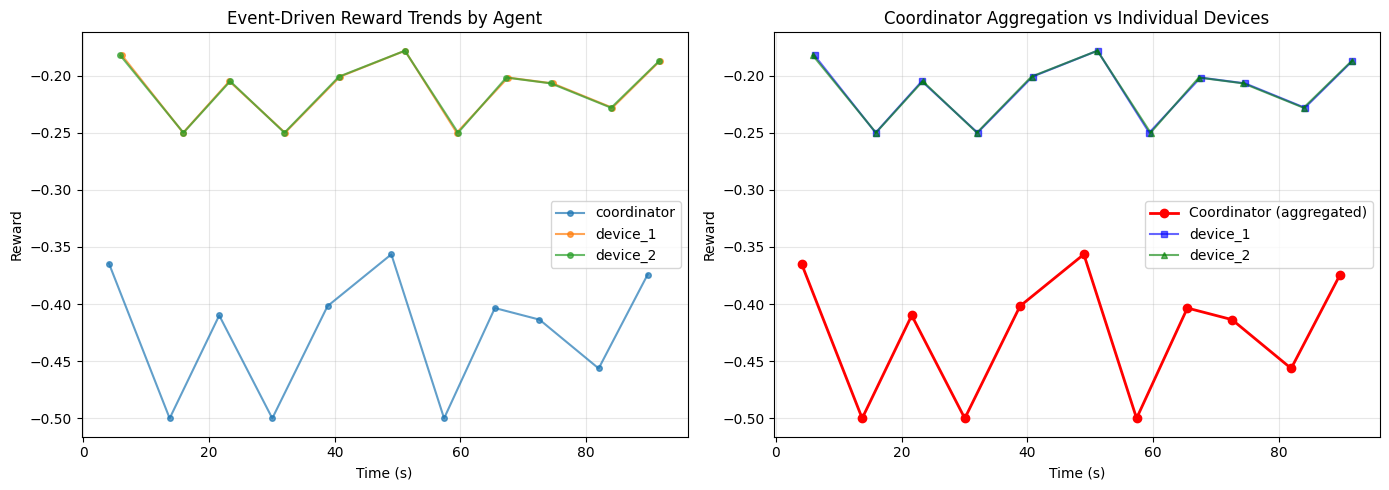


Coordinator Reward Stats (aggregated):
  Mean: -0.3900
  Std:  0.1278
  Min:  -0.5000
  Max:  0.0000

Note: Coordinator reward = sum of subordinate rewards (for monitoring)


In [15]:
# Extract and plot reward trends from event-driven execution
print("="*80)
print("Event-Driven Reward Trends")
print("="*80)

# Extract reward history from agents
reward_data = {"coordinator": [], "device_1": [], "device_2": []}
timestamps = {"coordinator": [], "device_1": [], "device_2": []}

for agent_id in ["coordinator", "device_1", "device_2"]:
    agent = env.registered_agents.get(agent_id)
    if agent and hasattr(agent, '_reward_history') and agent._reward_history:
        # Extract timestamps and rewards from history
        for timestamp, reward in agent._reward_history:
            timestamps[agent_id].append(timestamp)
            reward_data[agent_id].append(reward)
        print(f"  {agent_id}: {len(agent._reward_history)} reward data points")

# Plot reward trends
if any(len(rewards) > 0 for rewards in reward_data.values()):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Individual agent rewards over time
    for agent_id, rewards in reward_data.items():
        if len(rewards) > 0:
            ts = timestamps[agent_id]
            if agent_id == "coordinator":
                ts = ts[1:]
                rewards = rewards[1:]
            ax1.plot(ts, rewards, 'o-', label=agent_id, alpha=0.7, markersize=4)

    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Reward')
    ax1.set_title('Event-Driven Reward Trends by Agent')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Coordinator vs Device comparison
    if len(reward_data["coordinator"]) > 0:
        ax2.plot(timestamps["coordinator"][1:], reward_data["coordinator"][1:],
                'ro-', label='Coordinator (aggregated)', markersize=6, linewidth=2)

    if len(reward_data["device_1"]) > 0:
        ax2.plot(timestamps["device_1"], reward_data["device_1"],
                'bs-', label='device_1', markersize=4, alpha=0.6)

    if len(reward_data["device_2"]) > 0:
        ax2.plot(timestamps["device_2"], reward_data["device_2"],
                'g^-', label='device_2', markersize=4, alpha=0.6)

    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Reward')
    ax2.set_title('Coordinator Aggregation vs Individual Devices')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    if len(reward_data["coordinator"]) > 0:
        coord_rewards = reward_data["coordinator"]
        print(f"\nCoordinator Reward Stats (aggregated):")
        print(f"  Mean: {np.mean(coord_rewards):.4f}")
        print(f"  Std:  {np.std(coord_rewards):.4f}")
        print(f"  Min:  {np.min(coord_rewards):.4f}")
        print(f"  Max:  {np.max(coord_rewards):.4f}")
        print(f"\nNote: Coordinator reward = sum of subordinate rewards (for monitoring)")
else:
    print("\n⚠ No reward data captured")

---
## Summary

This tutorial demonstrated:

### 1. Action Protocols
- **ProportionalActionProtocol**: Distributes scalar action proportionally
- **VerticalProtocol** (VectorDecomposition): Splits joint action vector among subordinates
- Custom protocols can implement any action distribution logic

### 2. Hierarchical Action Passing
- **Coordinator owns policy**: Computes joint action for all subordinates
- **Protocol distributes**: Actions flow from coordinator to field agents
- **Field agents receive**: Actions via protocol (no local policies needed)

### 3. CTDE Training
- Coordinator observes all subordinates (aggregated observation)
- Coordinator computes joint action (single policy for all agents)
- Protocol distributes actions during training (matching execution)
- Update policy using aggregated rewards

### 4. Event-Driven Testing
- Same protocol works in event-driven mode
- Asynchronous action distribution with configurable delays
- Message broker handles communication between agents
- Realistic timing with jitter and delays

### Key Design Principles

**Clean Separation**:
- Policy logic: Coordinator level
- Action distribution: Protocol
- Execution: Field agent level

**Flexibility**:
- Swap protocols without changing agents
- Different protocols for different scenarios
- Custom protocols for domain-specific distribution

**Consistency**:
- Same protocol in training and testing
- Train once, deploy anywhere
- Robust to timing variability

### Next Steps

1. **Custom Protocols**: Implement domain-specific action distribution (e.g., priority-based, constraint-aware)
2. **Multi-Level Coordination**: Nest coordinators with different protocols at each level
3. **Communication Protocols**: Add message passing between agents (not just actions)
4. **Advanced Policies**: Multi-agent RL algorithms (QMIX, MADDPG) with protocol-based action passing